In [46]:
import metmhn.simulations as simul
import metmhn.Utilityfunctions as utils
import pandas as pd
import numpy as np
import jax as jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

Read in a saved metMHN:

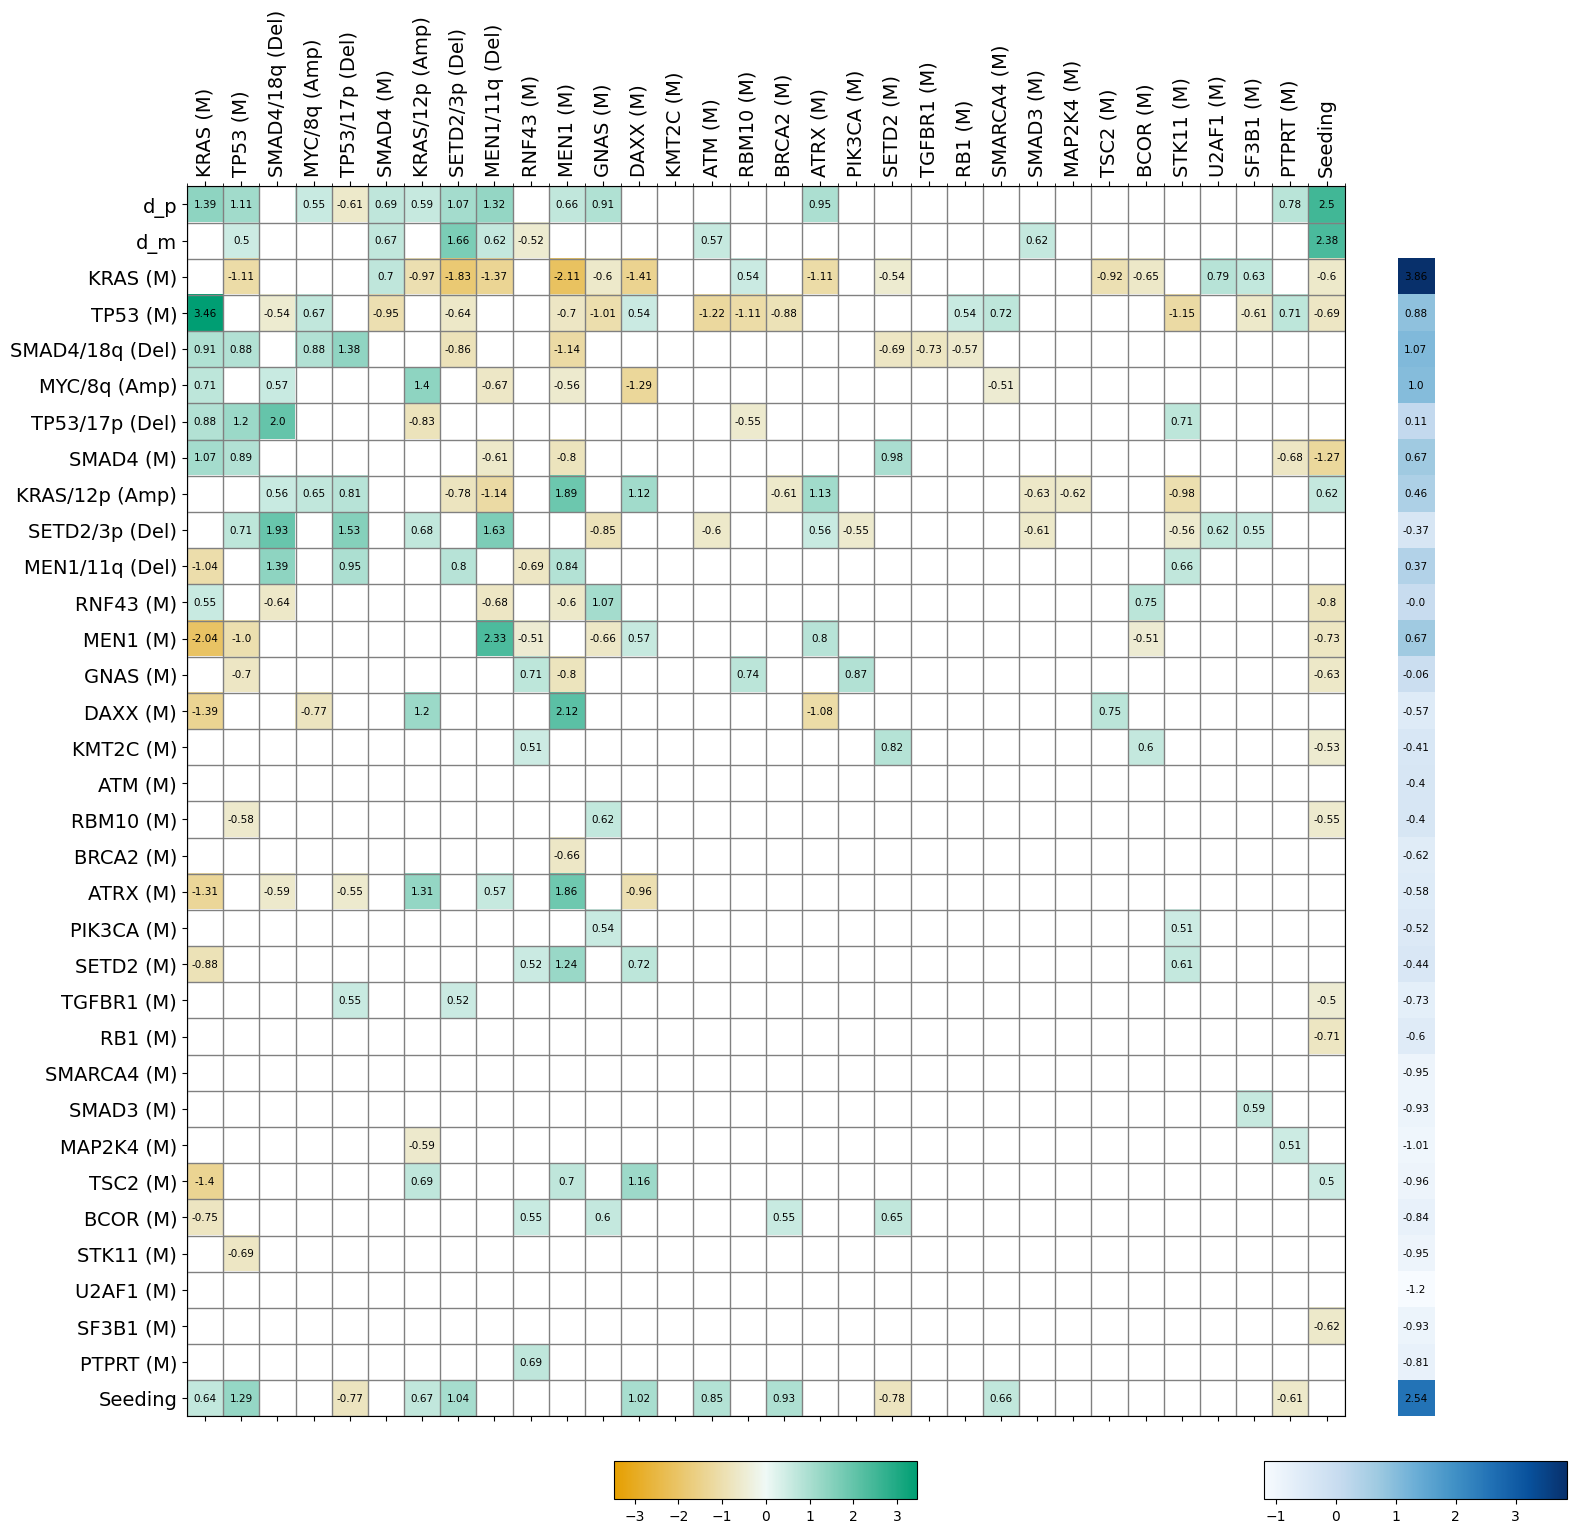

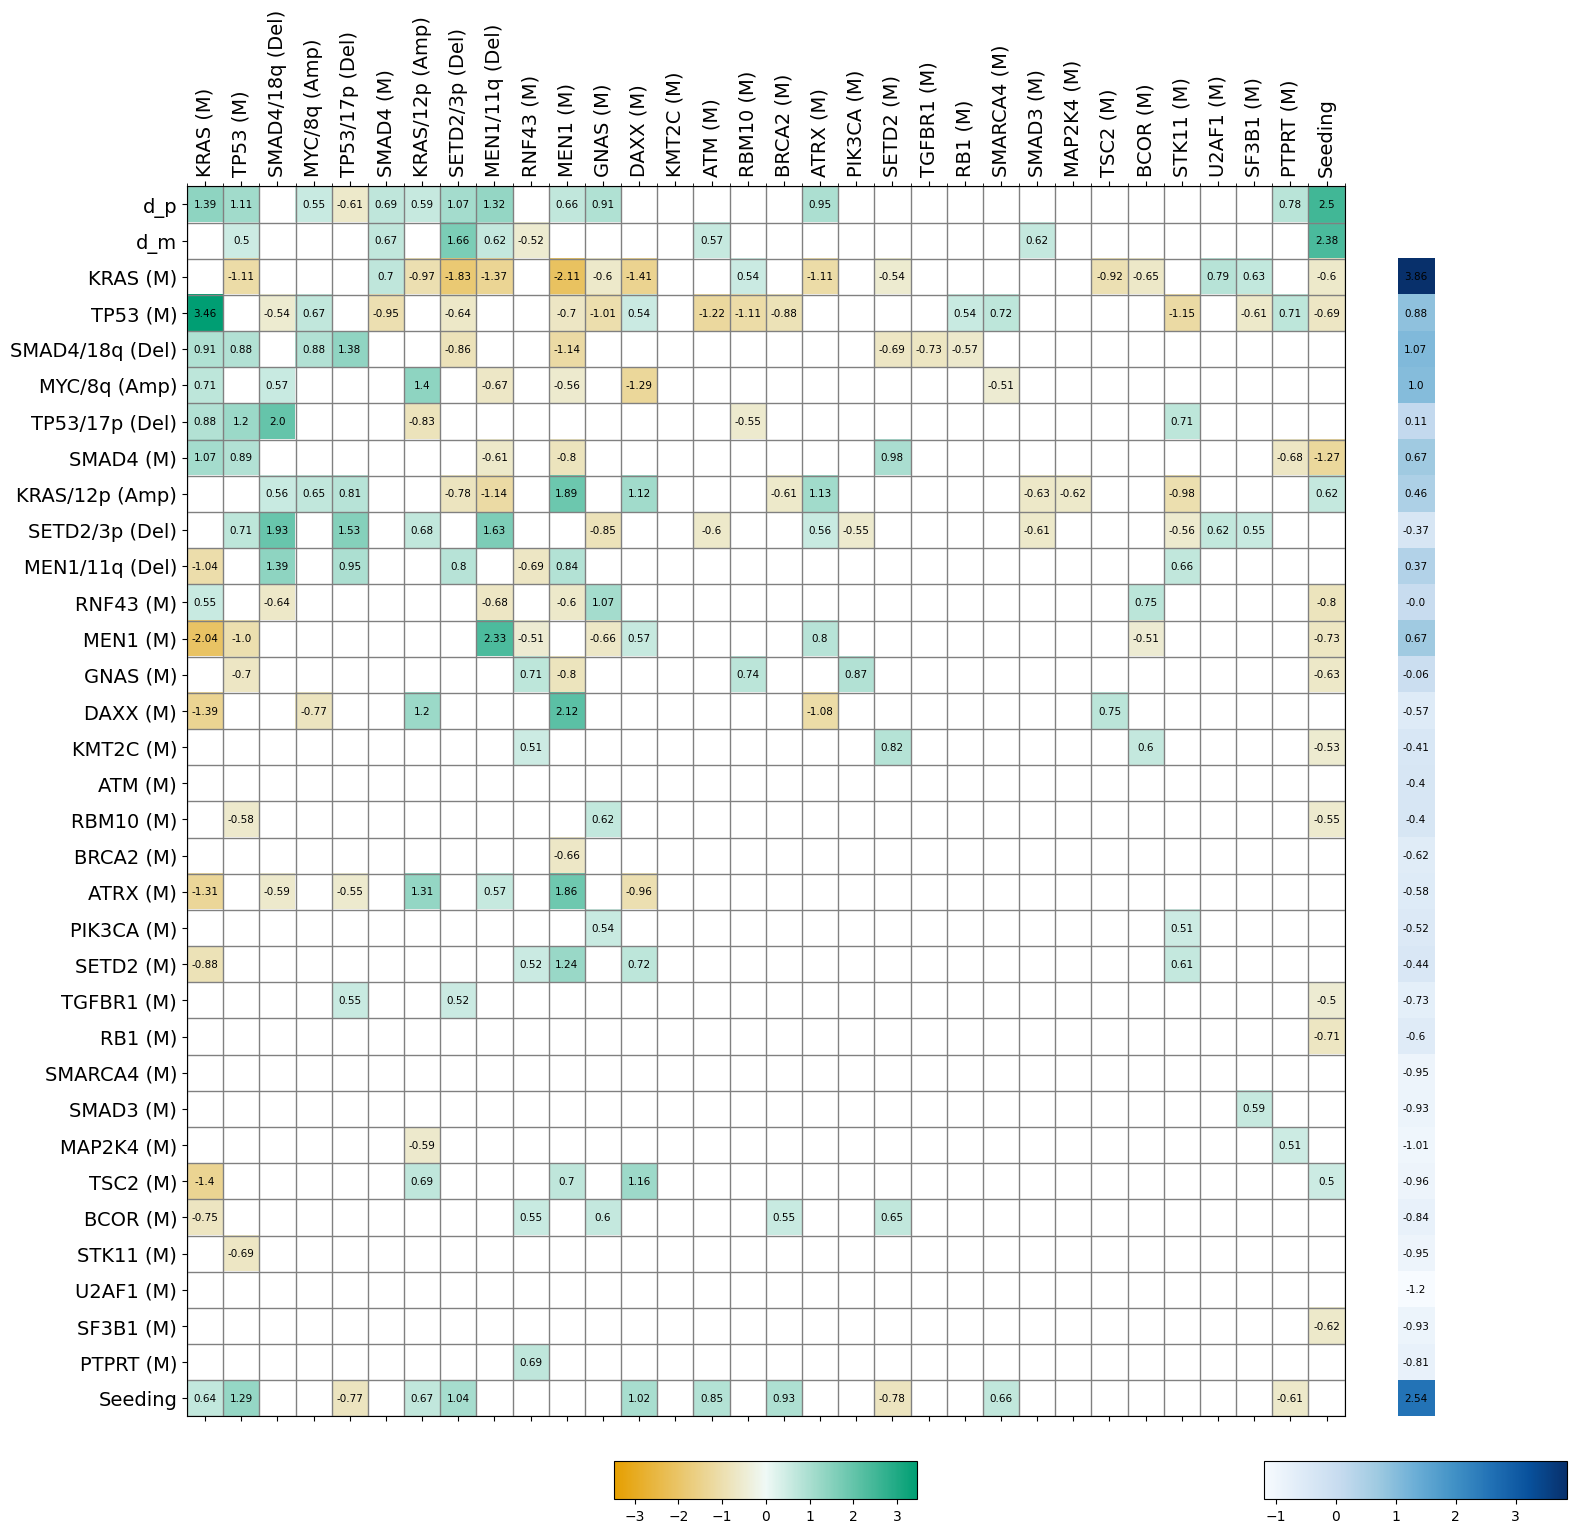

In [55]:
params = pd.read_csv("../results/prad/sim_upo.csv", index_col=0)
d_p = params.iloc[0,:].to_numpy()
d_m = params.iloc[1, :].to_numpy()
th = params.iloc[2:,:].to_numpy()
events = params.columns
n = th.shape[1]
rng = np.random.default_rng(seed=42)
utils.plot_theta(params.to_numpy(), events, 0.5, True, 7.5)

Calculate $P(t_{mut} < t_{seed}| x[mut] = 1)$ i.e. the probability that a mutation happend prior to the seeding for both primary tumors and metastases:

In [48]:
mut_ps, mut_total_prim, mut_total_met = simul.p_any_mut_pre_seed(np.array(th), np.array(d_p), np.array(d_m), 50000, rng)

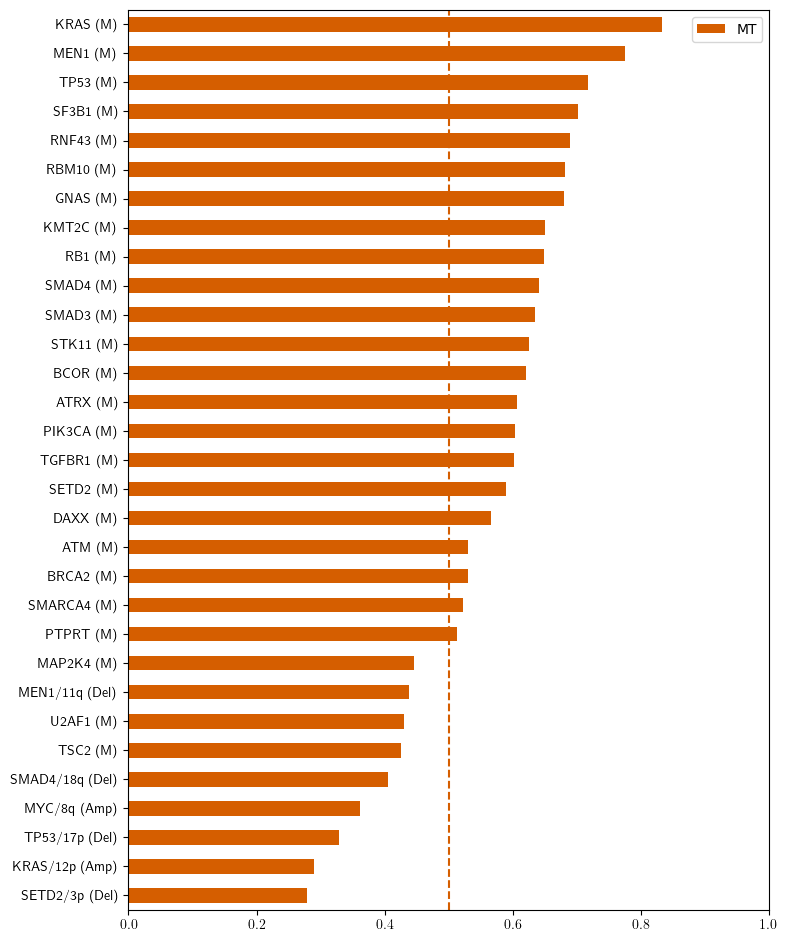

In [49]:
psp = pd.DataFrame(np.column_stack((mut_ps/mut_total_prim, mut_ps/mut_total_met)), 
                  index=events[:-1], columns=["PT", "MT"])
psp.sort_values(by=["MT"], inplace=True)
fig, ax = plt.subplots(figsize=(8.27, 11.69))

plt.style.use("default")
ax.set_xlim(0,1)
ax.axvline(0.5, color = "#D55E00", linestyle="dashed")
psp["MT"].plot(kind="barh", ax=ax, color="#D55E00")
ax.legend()

In [18]:
psp["n_sim"] = 50000

In [19]:
psp.iloc[0,:]

PS-Counts-PT       17736
Total-Counts-PT    23739
PS-Counts-MT       17736
Total-Counts-MT    26628
n_sim              50000
Name: TP53 (M), dtype: int64

In [24]:
psp.to_csv("../results/luad/luad_presseding_probs.csv")

Simulate genotypes according to the model and compare them to the real data:

In [50]:
dat = np.array(simul.simulate_dat_jax(jnp.array(th), jnp.array(d_p), jnp.array(d_m), 10000, seed = 4209090908979))
dat_prim_nomet = dat[dat[:,-2]==0,:-1]
dat_coupled = dat[dat[:,-2]==1,:-1]
dat_pt_first = dat[dat[:, -1] != 2, :]

In [51]:
n_mut = (th.shape[0]-1)
n_tot = n_mut + 1
arr = dat_coupled * np.array([1,2]*n_mut+[1])
arr = arr @ (np.diag([1,0]*n_mut+[1]) + np.diag([1,0]*n_mut, -1))

counts = np.zeros((4, n_tot))
for i in range(0,2*n_tot,2):
    i_h = int(i/2)
    for j in range(1,4):
        counts[j-1, i_h] = np.count_nonzero(arr[:,i]==j)/dat_coupled.shape[0]
    counts[3, i_h] = np.sum(dat_prim_nomet[:, i], axis=0)/dat_prim_nomet.shape[0]

labels = [["Coupled ("+str(dat_coupled.shape[0])+")"]*3 +\
        ["NM ("+str(dat_prim_nomet.shape[0])+")"],
        ["PT-Private", "MT-Private", "Shared"] + ["Present"]*3]
       
inds =  pd.MultiIndex.from_tuples(list(zip(*labels)))
counts = pd.DataFrame(np.around(counts, 2), columns=events, index=inds).T
counts

Coupled (8499)                   NM (1501)
                    PT-Private MT-Private Shared   Present
KRAS (M)                  0.07       0.05   0.78      0.78
TP53 (M)                  0.10       0.11   0.58      0.54
SMAD4/18q (Del)           0.07       0.20   0.20      0.34
MYC/8q (Amp)              0.05       0.19   0.14      0.20
TP53/17p (Del)            0.05       0.19   0.13      0.22
SMAD4 (M)                 0.06       0.06   0.12      0.21
KRAS/12p (Amp)            0.03       0.18   0.09      0.09
SETD2/3p (Del)            0.03       0.16   0.08      0.14
MEN1/11q (Del)            0.02       0.04   0.04      0.14
RNF43 (M)                 0.01       0.02   0.04      0.05
MEN1 (M)                  0.01       0.01   0.04      0.08
GNAS (M)                  0.01       0.01   0.03      0.06
DAXX (M)                  0.01       0.01   0.02      0.01
KMT2C (M)                 0.01       0.01   0.02      0.02
ATM (M)                   0.01       0.02   0.02      0.01
RBM10 (M)                 0.01       0.01   0.02      0.02
BRCA2 (M)                 0.00       0.01   0.01      0.00
ATRX (M)                  0.01       0.01   0.01      0.03
PIK3CA (M)                0.00       0.01   0.02      0.02
SETD2 (M)                 0.01       0.01   0.01      0.03
TGFBR1 (M)                0.01       0.01   0.01      0.02
RB1 (M)                   0.01       0.01   0.01      0.02
SMARCA4 (M)               0.00       0.01   0.01      0.01
SMAD3 (M)                 0.00       0.01   0.01      0.01
MAP2K4 (M)                0.00       0.01   0.01      0.02
TSC2 (M)                  0.00       0.01   0.01      0.01
BCOR (M)                  0.00       0.01   0.01      0.01
STK11 (M)                 0.00       0.01   0.01      0.01
U2AF1 (M)                 0.00       0.01   0.01      0.01
SF3B1 (M)                 0.00       0.01   0.01      0.01
PTPRT (M)                 0.00       0.01   0.01      0.03
Seeding                   1.00       0.00   0.00      0.00

Calculate $P(t_{mut} < t_{seed} | x[mut] = z[mut] = 1)$ ie. the probability that a **shared** mutation between the primary tumor and the metastasis happened prior to the seeding

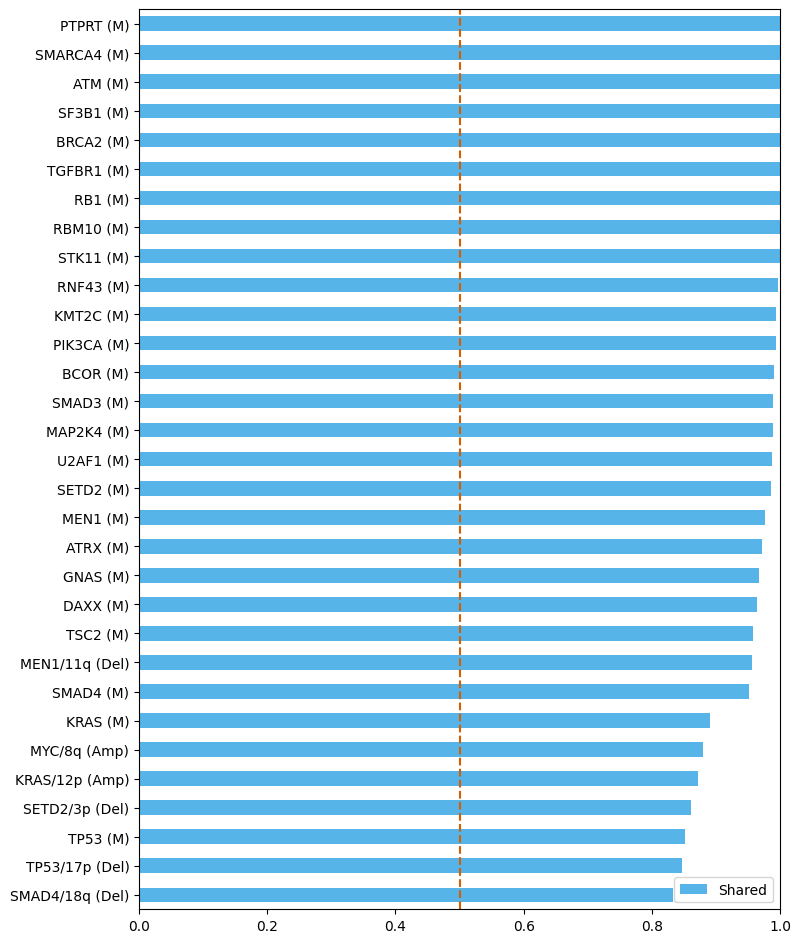

In [52]:
mut_ps, mut_total = simul.p_shared_mut_pre_seed(th, d_p, d_m, 10000, rng)
psp = pd.DataFrame(mut_ps/mut_total, index=events[:-1], columns=["Shared"])
psp.sort_values(by=["Shared"], inplace=True)
fig, ax = plt.subplots(figsize=(8.27, 11.69))
plt.style.use("default")
ax.set_xlim(0,1)
ax.axvline(0.5, color = "#D55E00", linestyle="dashed")
psp["Shared"].plot(kind="barh", color="#56B4E9", ax=ax)
ax.legend()